# E-ML - Phishing Email Detection with Machine Learning Methods
### By Colin Harrison, Aidan Huerta, and Drew Levy
--- 

In [1]:
print("Importing necessary libraries...\n")

import datasets
import re
import requests
import nltk
import sklearn
import torch
import random

import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from nltk import word_tokenize, FreqDist, pos_tag

from sklearn import linear_model, metrics

from sklearn.feature_extraction.text import *

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.linear_model import LogisticRegression


from transformers import AutoTokenizer, AutoModel


from typing import Any, Dict, Iterable, List, Optional, Set, Tuple


# Might be necessary
nltk.download('punkt_tab', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('universal_tagset', quiet=True)

# Set the Seeds
SEED = 42
random.seed(SEED)

np.random.seed(SEED)

torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Set the Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("WARNING: no GPU detected; training may be slow")

print("\nDone!")

Importing necessary libraries...

Using device: cpu

Done!


In [2]:
# Load and Split Data
data_df = pd.read_csv('Phishing_Email.csv')
train_size = .8
validation_size = .1
test_size = .1

# Uses global Seed for random_state
train_df, temp_df = train_test_split(data_df, train_size = train_size, random_state= SEED)
validation_df, test_df = train_test_split(temp_df, test_size=.5, random_state= SEED)

# Configure Pandas Display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 70)
pd.set_option('display.expand_frame_rep', False)


print("Training Data shape:", train_df.shape)
print("Validation Data shape:", validation_df.shape)
print("Testing Data shape:", test_df.shape)
print()
print("Below is a small sample of what the data we will be using looks like:")

sample_phishing = train_df[train_df['Email Type'] == 'Phishing Email'].sample(n=3, random_state=SEED)
sample_safe = train_df[train_df['Email Type'] == 'Safe Email'].sample(n=3, random_state=SEED)

print(pd.concat([sample_phishing, sample_safe]))

Training Data shape: (14920, 3)
Validation Data shape: (1865, 3)
Testing Data shape: (1865, 3)

Below is a small sample of what the data we will be using looks like:
      Unnamed: 0                                                             Email Text      Email Type
6199        6199  sorry , one more thing cheating adult personals get laid now . rea...  Phishing Email
5658        5658  payment representative dear sir / madam , i am mr . liu peijin , m...  Phishing Email
5466        5466  When Economy goes down, WE go UP !$3000 COMMISSION per Sale for YO...  Phishing Email
7321        7322  fifth annual graduate romanic association at the u . of penn . * *...      Safe Email
3140        3140  december conference preliminary announcement first international w...      Safe Email
3510        3510  re : term project : brian , no problem . vince " brian corbett nel...      Safe Email


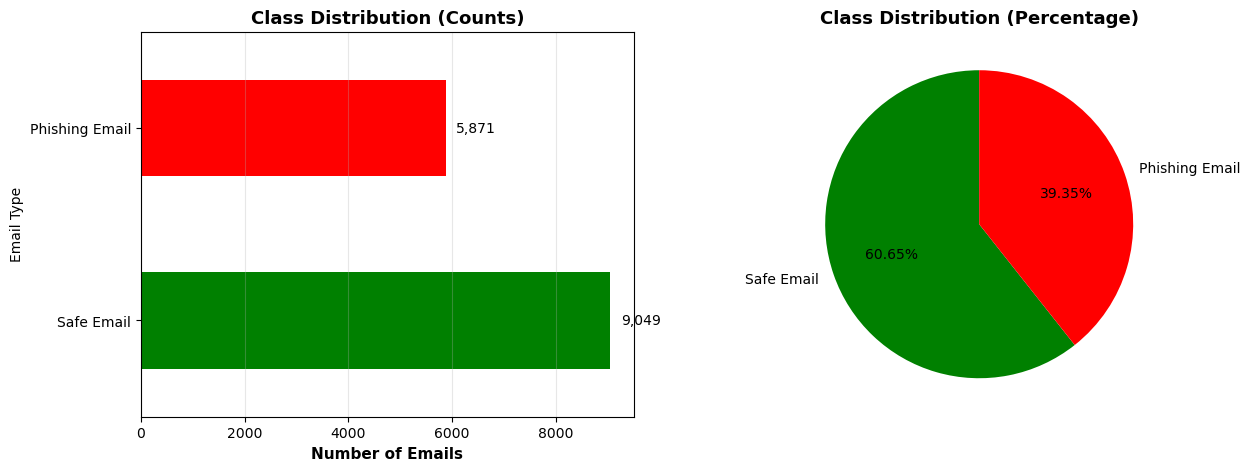

In [3]:
label_cols = ["Email Type"]
counts = train_df[label_cols[0]].value_counts().sort_values(ascending=False)
percentages = (counts / len(train_df)) *100

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

colors = ["green", "red"]
counts.plot(kind='barh', ax=ax1, color=colors)
ax1.set_xlabel('Number of Emails', fontsize=11, fontweight='bold')
ax1.set_title('Class Distribution (Counts)', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for i, (label, value) in enumerate(counts.items()):
    ax1.text(value + 200, i, f'{value:,}', va='center', fontsize=10)

percentages.plot(kind='pie', ax=ax2, colors=colors, autopct='%1.2f%%', startangle=90)
ax2.set_title('Class Distribution (Percentage)', fontsize=13, fontweight='bold')
ax2.set_ylabel('')
plt.show()

## We know the following
---

In [4]:
for label in counts.index:
    count = counts[label]
    pct = percentages[label]
    ratio = int(len(train_df) / count)
    print(f"{label:<20} {count:>12,} {pct:>11.2f}%")
print(f"{'Total Samples':<20} {len(train_df):>12,}")

Safe Email                  9,049       60.65%
Phishing Email              5,871       39.35%
Total Samples              14,920


### Thus if we can achieve accuracies above this percentages we have learned something about the data

## Linear Classification Baselines ##

### Logistic Regression with Bag-of-Words Features ###

In [5]:
train_email_text = train_df["Email Text"].fillna("")
validation_email_text = validation_df["Email Text"].fillna("")

print("Initializing CountVectorizer (unigrams + bigrams, stopwords removed)...\n")
vectorizer = CountVectorizer(stop_words = 'english', ngram_range=(1,2) )

print("Vectorizing training email text (learning vocabulary)...")
X_train = vectorizer.fit_transform(train_email_text)

print("Vectorizing validation email text using learned vocabulary...\n")
X_val = vectorizer.transform(validation_email_text)

print(f"Vocabulary size (number of features): {X_train.shape[1]}")

print("Encoding email labels as binary values (1 = phishing, 0 = safe)\n")
Y_train = (train_df["Email Type"] == "Phishing Email").astype(int)
Y_val = (validation_df["Email Type"] == "Phishing Email").astype(int)


Initializing CountVectorizer (unigrams + bigrams, stopwords removed)...

Vectorizing training email text (learning vocabulary)...
Vectorizing validation email text using learned vocabulary...

Vocabulary size (number of features): 1445686
Encoding email labels as binary values (1 = phishing, 0 = safe)



In [6]:
print("Training Logistic Regression classifier with Bag-of-Words Features...\n")
lr_classifier = LogisticRegression(penalty="l2",max_iter=3000,random_state = SEED)

lr_classifier.fit(X_train, Y_train)

y_pred = lr_classifier.predict(X_val)

y_proba = lr_classifier.predict_proba(X_val)[:, 1]

print("Evaluating model performance on validation data...")
print("Validation Accuracy:", accuracy_score(Y_val, y_pred))
print("Validation AUROC:", roc_auc_score(Y_val, y_proba))

print("\nDetailed Classification Report:")
print(classification_report(Y_val, y_pred, target_names=["Safe Email", "Phishing Email"]))


Training Logistic Regression classifier with Bag-of-Words Features...

Evaluating model performance on validation data...
Validation Accuracy: 0.9726541554959786
Validation AUROC: 0.9916834951034679

Detailed Classification Report:
                precision    recall  f1-score   support

    Safe Email       0.99      0.96      0.98      1134
Phishing Email       0.95      0.98      0.97       731

      accuracy                           0.97      1865
     macro avg       0.97      0.97      0.97      1865
  weighted avg       0.97      0.97      0.97      1865



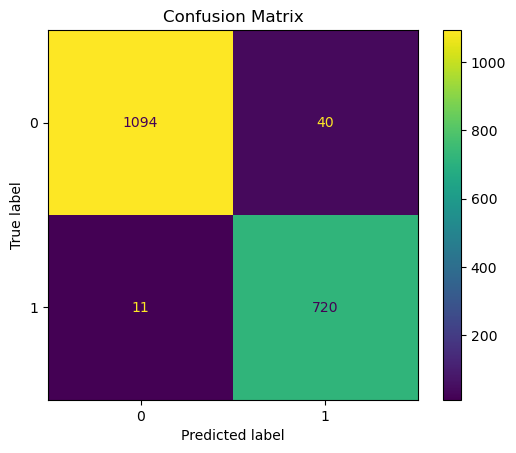

In [7]:
y_pred = lr_classifier.predict(X_val)
c_matrix = confusion_matrix(Y_val, y_pred)
ConfusionMatrixDisplay(confusion_matrix=c_matrix).plot()
plt.title('Confusion Matrix')
plt.show()

## Discusion:
---
We classify most emails properly, even with this super simple model. We do notice that a majority of the emails we get incorrect are false positives, which could cause disruption when legitimate emails are quarantined. We look to further improve our accuracy with more advanced models.

### Logistic Regression with TF-IDF Features ###

In [8]:
# These remain the same for both feature types # 
train_email_text = train_email_text
validation_email_text = validation_email_text

print("Initializing TF-IDF Vectorizer (unigrams + bigrams, stopwords removed)...\n")
tf_idf_vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    min_df=2,          # helps remove noise
    max_df=0.95,       # ignore extremely common terms
    sublinear_tf=True  # 1 + log(tf)
)

print("Vectorizing training email text (learning vocabulary)...")
X_train = tf_idf_vectorizer.fit_transform(train_email_text)

print("Vectorizing validation email text using learned vocabulary...\n")
X_val = tf_idf_vectorizer.transform(validation_email_text)

print(f"Vocabulary size (number of features): {X_train.shape[1]}")

# These remain the same for both feature types # 
print("Encoding email labels as binary values (1 = phishing, 0 = safe)\n")
Y_train = Y_train
Y_val = Y_val

Initializing TF-IDF Vectorizer (unigrams + bigrams, stopwords removed)...

Vectorizing training email text (learning vocabulary)...
Vectorizing validation email text using learned vocabulary...

Vocabulary size (number of features): 636676
Encoding email labels as binary values (1 = phishing, 0 = safe)



In [9]:
print("Training Logistic Regression classifier with TF-IDF Features...\n")
tf_idf_lr_classifier = LogisticRegression(penalty="l2",max_iter=3000,random_state = SEED )

tf_idf_lr_classifier.fit(X_train, Y_train)

y_pred = tf_idf_lr_classifier.predict(X_val)

y_proba = tf_idf_lr_classifier.predict_proba(X_val)[:, 1]

print("Evaluating model performance on test data...")
print("Validation Accuracy:", accuracy_score(Y_val, y_pred))
print("Validation AUROC:", roc_auc_score(Y_val, y_proba))

print("\nDetailed Classification Report (TF-IDF Features):")
print(classification_report(Y_val, y_pred, target_names=["Safe Email", "Phishing Email"]))

Training Logistic Regression classifier with TF-IDF Features...

Evaluating model performance on test data...
Validation Accuracy: 0.9753351206434316
Validation AUROC: 0.995306132789033

Detailed Classification Report (TF-IDF Features):
                precision    recall  f1-score   support

    Safe Email       0.98      0.98      0.98      1134
Phishing Email       0.96      0.98      0.97       731

      accuracy                           0.98      1865
     macro avg       0.97      0.98      0.97      1865
  weighted avg       0.98      0.98      0.98      1865



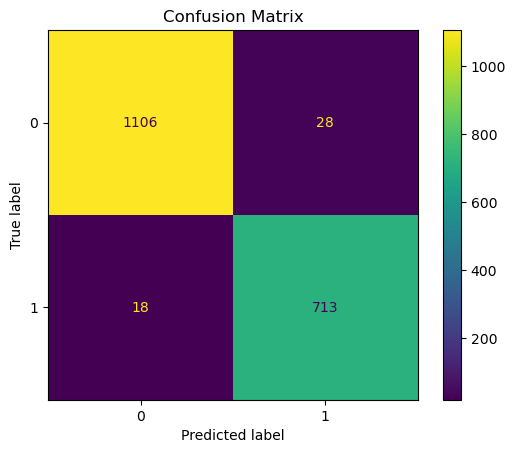

In [10]:
y_pred = tf_idf_lr_classifier.predict(X_val)
c_matrix = confusion_matrix(Y_val, y_pred)
ConfusionMatrixDisplay(confusion_matrix=c_matrix).plot()
plt.title('Confusion Matrix')
plt.show()